In [1]:
from pathlib import Path
import re
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import interpolate

In [28]:
# Define standard column aliases
T = 'Test_Time(s)'
I = 'Current(A)'
V = 'Voltage(V)'
V_sm = 'Voltage_sm (V)'
Qc = 'Charge_Capacity(Ah)'
Qd = 'Discharge_Capacity(Ah)'
Ec = 'Charge_Energy(Wh)'
Ed = 'Discharge_Energy(Wh)'
P = 'Power(W)'

In [29]:
df = pd.read_excel(r"D:\FUSE 2025 SUM\battery-analysis-project\Data\raw_data\03-CONSTANT CURRENT protocol_Cycles 0 to 1000\Cycle 0370\CC_eleven_Channel_5_Wb_1.xlsx") # randomly picked

In [30]:
print(df.columns.tolist())

['Data_Point', 'Date_Time', 'Test_Time(s)', 'Step_Time(s)', 'Cycle_Index', 'Step_Index', 'TC_Counter1', 'TC_Counter2', 'TC_Counter3', 'TC_Counter4', 'Current(A)', 'Voltage(V)', 'Power(W)', 'Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'ACR(Ohm)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'dQ/dV(Ah/V)', 'dV/dQ(V/Ah)', 'MetaCode_MV_UD3', 'Aux_Temperature_5(C)', 'Aux_dT/dt_5(C)', 'Aux_Digital Output_1', 'Aux_Digital Output_2', 'Aux_Digital Output_3', 'Aux_Digital Output_4', 'Aux_Digital Output_5', 'Aux_Digital Output_6', 'Aux_Digital Output_7', 'Aux_Digital Output_8']


In [43]:
df = df[df['Cycle_Index']==1] # pick out a nice, complete cycle - info from previous work

Text(0.5, 1.0, 'Raw P-E Curve')

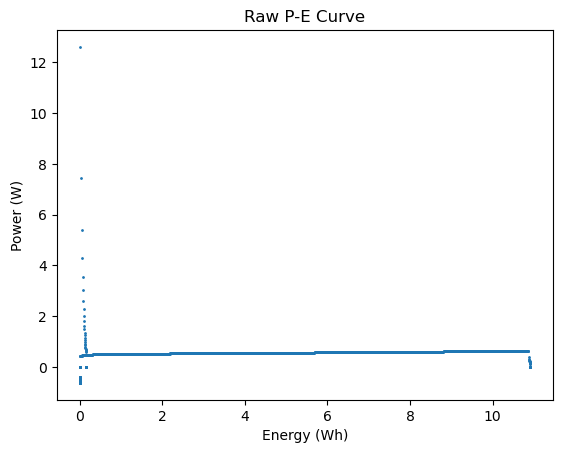

In [44]:
# check reliability of the P, E columns in the Borealis dataset
plt.plot(df[Ec], df[P], linestyle = 'none', marker = 'o', markersize = 1)
plt.xlabel("Energy (Wh)")
plt.ylabel("Power (W)")
plt.title("Raw P-E Curve")

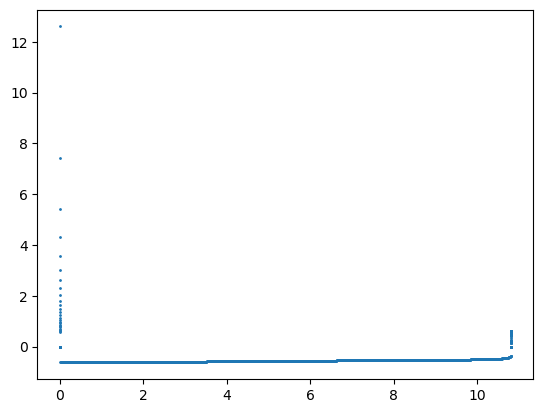

In [45]:
plt.plot(df[Ed], df[P], linestyle = 'none', marker = 'o', markersize = 1)

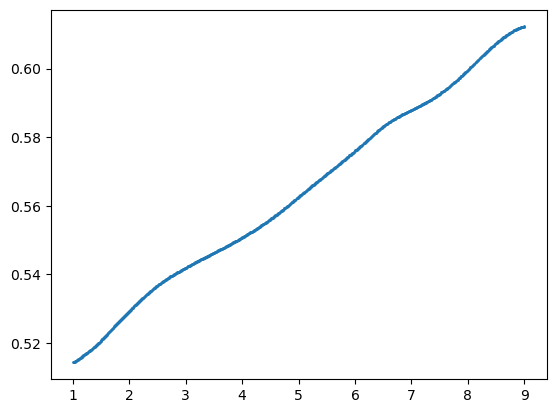

In [48]:
mask = (df[Ec] > 1) & (df[Ec] < 9)
plt.plot(df[Ec][mask], df[P][mask], linestyle='none', marker='o', markersize=1)

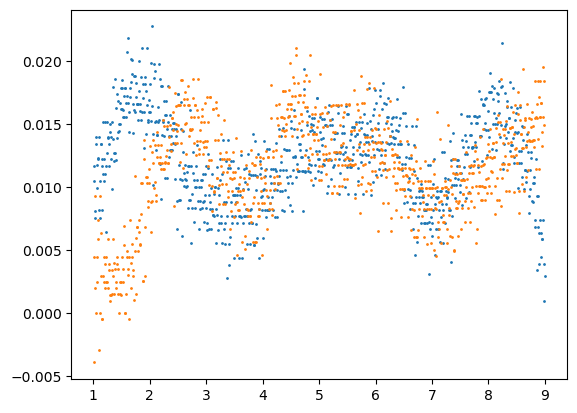

In [50]:
# check dPdE computed by raw P and E
charge = [P, Ec]
discharge = [P, Ed]

mask_c = df[charge].isna().any(axis = 1)|(df[charge]==0).any(axis=1)
mask_d = df[discharge].isna().any(axis = 1)|(df[discharge]==0).any(axis=1)

cleaned_c = df[~mask_c]
cleaned_d = df[~mask_d]

mask_c = (cleaned_c[Ec] > 1) & (cleaned_c[Ec] < 9)
mask_d = (cleaned_d[Ed] > 1) & (cleaned_d[Ed] < 9)

Pc, Ec_vals = cleaned_c[P][mask_c].values, cleaned_c[Ec][mask_c].values
dPdE_c = np.gradient(Pc, Ec_vals)
Pd, Ed_vals = cleaned_d[P][mask_d].values, cleaned_d[Ed][mask_d].values
dPdE_d = np.gradient(Pd, Ed_vals)

plt.plot(Ec_vals, dPdE_c, linestyle='none', marker='o', markersize=1)
plt.plot(Ed_vals, dPdE_d, linestyle='none', marker='o', markersize=1)

In [51]:
print(np.all(np.diff(Ec_vals) > 0)) # 'True' if monotonic

True


In [52]:
print(np.sum(np.diff(Ec_vals) == 0)) # check repeating

0


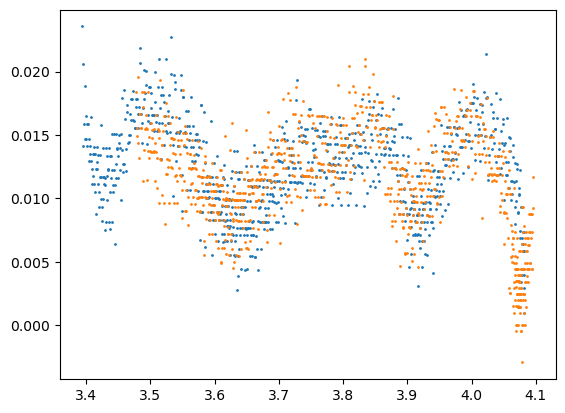

In [63]:
# try plotting against voltage
charge = [P, Ec, V]
discharge = [P, Ed, V]

mask_c = df[charge].isna().any(axis = 1)|(df[charge]==0).any(axis=1)
mask_d = df[discharge].isna().any(axis = 1)|(df[discharge]==0).any(axis=1)

cleaned_c = df[~mask_c]
cleaned_d = df[~mask_d]

mask_c = (cleaned_c[Ec] > 0.6) & (cleaned_c[Ec] < 9)
mask_d = (cleaned_d[Ed] > 0.6) & (cleaned_d[Ed] < 9)

Pc, Ec_vals, Vc = cleaned_c[P][mask_c].values, cleaned_c[Ec][mask_c].values, cleaned_c[V][mask_c].values
dPdE_c = np.gradient(Pc, Ec_vals)
Pd, Ed_vals, Vd = cleaned_d[P][mask_d].values, cleaned_d[Ed][mask_d].values, cleaned_d[V][mask_d].values
dPdE_d = np.gradient(Pd, Ed_vals)

plt.plot(Vc, dPdE_c, linestyle='none', marker='o', markersize=1)
plt.plot(Vd, dPdE_d, linestyle='none', marker='o', markersize=1)

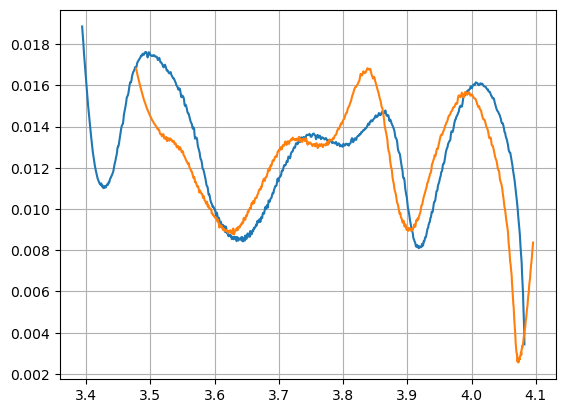

In [66]:
# try to apply some smoothing to dPdE curve
from scipy.signal import savgol_filter
dpde_smooth_c = savgol_filter(dPdE_c, window_length=75, polyorder=3)
plt.plot(Vc, dpde_smooth_c, label='Smoothed')

dpde_smooth_d = savgol_filter(dPdE_d, window_length=75, polyorder=3)
plt.plot(Vd, dpde_smooth_d, label='Smoothed')
plt.grid(True)

In [ ]:
# raw P-E looked already pretty smooth, perfectly monotonic after selecting E region
# but dPdE graph still noisy -> apply smoothing -> consistent shape with dVdQ
# question for tmr: does it need smoothing before gradient is computed?